In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

import wandb
from wandb.integration.keras import WandbCallback


import carbontracker
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense, LSTM, Dropout
import tensorflow as tf
import codecarbon
from codecarbon import EmissionsTracker
from sklearn.preprocessing import MinMaxScaler

In [4]:
# Create a tracker
tracker = EmissionsTracker(project_name="tensorflow_experiment")
tracker.start()

[codecarbon WARNING @ 14:44:20] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 14:44:20] [setup] RAM Tracking...
[codecarbon INFO @ 14:44:20] [setup] CPU Tracking...
[codecarbon WARNING @ 14:44:22] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 14:44:22] CPU Model on constant consumption mode: 11th Gen Intel(R) Core(TM) i7-1185G7 @ 3.00GHz
[codecarbon WARNING @ 14:44:22] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:44:22] [setup] GPU Tracking...
[codecarbon INFO @ 14:44:22] No GPU found.
[codecarbon INFO @ 14:44:22] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 14:44:22] >>> Tracker's metadat

In [18]:
data_dir = 'data/DailyDelhiClimateTrain.csv'
df = pd.read_csv(data_dir)

In [19]:
# Initialize a W&B run and set hyperparameters
wandb.init(
    project="MLOPS-Hackathon",   # Name of your project
    entity="emiliewedenborg-technical-university-of-denmark",  # Replace with your W&B entity
    name="temperature-forecasting-lstm",  # Name of the run

    config={
        "epochs": 10,
        "batch_size": 32,
        "learning_rate": 0.001,
        "optimizer": "adam"
    }
)

config = wandb.config


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


In [20]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace= True)

n_cols = 1
dataset = df["meantemp"]
dataset = pd.DataFrame(dataset)
data = dataset.values

data.shape

(1462, 1)

In [21]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range= (0, 1))
scaled_data = scaler.fit_transform(np.array(data))

In [22]:
train_size = int(len(data) * 0.75)
test_size = len(data) - train_size
print("Train Size :",train_size,"Test Size :",test_size)

Train Size : 1096 Test Size : 366


In [23]:
train_data = scaled_data[0:train_size, :]
train_data.shape

(1096, 1)

In [ ]:
# Creating a Training set with 60 time-steps
x_train = []
y_train = []
time_steps = 60
n_cols = 1

for i in range(time_steps, len(scaled_data)):
    x_train.append(scaled_data[i-time_steps:i, :n_cols])
    y_train.append(scaled_data[i, :n_cols])

[codecarbon INFO @ 14:45:11] Energy consumed for RAM : 0.000250 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:45:11] Delta energy consumed for CPU with constant : 0.000467 kWh, power : 112.0 W
[codecarbon INFO @ 14:45:11] Energy consumed for All CPU : 0.001401 kWh
[codecarbon INFO @ 14:45:11] 0.001651 kWh of electricity used since the beginning.


In [25]:
# Convert to numpy array
x_train, y_train = np.array(x_train), np.array(y_train)

In [26]:
# Reshaping the input to (n_samples, time_steps, n_feature)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], n_cols))

In [27]:
x_train.shape , y_train.shape

((1402, 60, 1), (1402, 1))

[codecarbon INFO @ 14:45:16] Energy consumed for RAM : 0.000416 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:45:16] Delta energy consumed for CPU with constant : 0.000467 kWh, power : 112.0 W


In [28]:
model = Sequential([
    LSTM(50, return_sequences= True, input_shape= (x_train.shape[1], n_cols)),
    LSTM(64, return_sequences= False),
    Dense(32),
    Dense(16),
    Dense(n_cols)
])

model.compile(optimizer= 'adam', loss= 'mse' , metrics= ["mean_absolute_error"])

[codecarbon INFO @ 14:45:16] Energy consumed for All CPU : 0.002334 kWh
c:\Users\aejew\OneDrive - Danmarks Tekniske Universitet\Dokumenter\GitHub\MLOPS-Hackathon\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[codecarbon INFO @ 14:45:16] 0.002751 kWh of electricity used since the beginning.


In [29]:
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        29,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,465 (165.88 KB)

 Trainable params: 42,465 (165.88 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    x_train, 
    y_train, 
    epochs=100, 
    batch_size=32, 
    callbacks=[WandbCallback(save_graph=False)]
)


Epoch 1/100


20/44 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.1157 - mean_absolute_error: 0.2690

[codecarbon INFO @ 14:45:41] Energy consumed for RAM : 0.000416 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:45:41] Delta energy consumed for CPU with constant : 0.000467 kWh, power : 112.0 W
[codecarbon INFO @ 14:45:41] Energy consumed for All CPU : 0.002334 kWh
[codecarbon INFO @ 14:45:41] 0.002751 kWh of electricity used since the beginning.


44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.0315 - mean_absolute_error: 0.1308
Epoch 2/100
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0069 - mean_absolute_error: 0.0651

[codecarbon INFO @ 14:45:46] Energy consumed for RAM : 0.000583 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:45:46] Delta energy consumed for CPU with constant : 0.000467 kWh, power : 112.0 W
[codecarbon INFO @ 14:45:46] Energy consumed for All CPU : 0.003267 kWh
[codecarbon INFO @ 14:45:46] 0.003850 kWh of electricity used since the beginning.


44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - loss: 0.0061 - mean_absolute_error: 0.0616
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 0.0051 - mean_absolute_error: 0.0563
Epoch 4/100
38/44 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0049 - mean_absolute_error: 0.0552

[codecarbon INFO @ 14:45:56] Energy consumed for RAM : 0.000499 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:45:56] Delta energy consumed for CPU with constant : 0.000467 kWh, power : 112.0 W


39/44 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0049 - mean_absolute_error: 0.0552

[codecarbon INFO @ 14:45:56] Energy consumed for All CPU : 0.002801 kWh
[codecarbon INFO @ 14:45:56] 0.003300 kWh of electricity used since the beginning.


44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - loss: 0.0048 - mean_absolute_error: 0.0551
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - loss: 0.0048 - mean_absolute_error: 0.0544
Epoch 6/100
14/44 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 0.0053 - mean_absolute_error: 0.0580

[codecarbon INFO @ 14:46:01] Energy consumed for RAM : 0.000666 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:46:01] Delta energy consumed for CPU with constant : 0.000467 kWh, power : 112.0 W


15/44 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0053 - mean_absolute_error: 0.0580

[codecarbon INFO @ 14:46:01] Energy consumed for All CPU : 0.003734 kWh
[codecarbon INFO @ 14:46:01] 0.004400 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:46:01] 0.005555 g.CO2eq/s mean an estimation of 175.18083588285953 kg.CO2eq/year


44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 0.0048 - mean_absolute_error: 0.0547
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.0046 - mean_absolute_error: 0.0532
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 0.0048 - mean_absolute_error: 0.0539
Epoch 9/100
14/44 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.0043 - mean_absolute_error: 0.0521

[codecarbon INFO @ 14:46:11] Energy consumed for RAM : 0.000583 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:46:11] Delta energy consumed for CPU with constant : 0.000467 kWh, power : 112.0 W


15/44 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.0043 - mean_absolute_error: 0.0521

[codecarbon INFO @ 14:46:11] Energy consumed for All CPU : 0.003268 kWh
[codecarbon INFO @ 14:46:11] 0.003851 kWh of electricity used since the beginning.


44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.0045 - mean_absolute_error: 0.0522
Epoch 10/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0044 - mean_absolute_error: 0.0523

[codecarbon INFO @ 14:46:16] Energy consumed for RAM : 0.000749 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:46:16] Delta energy consumed for CPU with constant : 0.000466 kWh, power : 112.0 W
[codecarbon INFO @ 14:46:16] Energy consumed for All CPU : 0.004201 kWh
[codecarbon INFO @ 14:46:16] 0.004950 kWh of electricity used since the beginning.


44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.0043 - mean_absolute_error: 0.0518
Epoch 11/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.0046 - mean_absolute_error: 0.0535
Epoch 12/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 0.0041 - mean_absolute_error: 0.0500
Epoch 13/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.0041 - mean_absolute_error: 0.0503
Epoch 14/100


[codecarbon INFO @ 14:46:26] Energy consumed for RAM : 0.000666 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:46:26] Delta energy consumed for CPU with constant : 0.000467 kWh, power : 112.0 W
[codecarbon INFO @ 14:46:26] Energy consumed for All CPU : 0.003734 kWh
[codecarbon INFO @ 14:46:26] 0.004400 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:46:26] 0.005556 g.CO2eq/s mean an estimation of 175.2041503508902 kg.CO2eq/year


44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.0040 - mean_absolute_error: 0.0494
Epoch 15/100


[codecarbon INFO @ 14:46:31] Energy consumed for RAM : 0.000832 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:46:31] Delta energy consumed for CPU with constant : 0.000466 kWh, power : 112.0 W
[codecarbon INFO @ 14:46:31] Energy consumed for All CPU : 0.004667 kWh
[codecarbon INFO @ 14:46:31] 0.005499 kWh of electricity used since the beginning.


44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - loss: 0.0039 - mean_absolute_error: 0.0488
Epoch 16/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 0.0041 - mean_absolute_error: 0.0501
Epoch 17/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 0.0037 - mean_absolute_error: 0.0476
Epoch 18/100
 1/44 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - loss: 0.0032 - mean_absolute_error: 0.0440

[codecarbon INFO @ 14:46:41] Energy consumed for RAM : 0.000749 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:46:41] Delta energy consumed for CPU with constant : 0.000467 kWh, power : 112.0 W
[codecarbon INFO @ 14:46:41] Energy consumed for All CPU : 0.004201 kWh
[codecarbon INFO @ 14:46:41] 0.004950 kWh of electricity used since the beginning.


44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.0038 - mean_absolute_error: 0.0479
Epoch 19/100
 1/44 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - loss: 0.0035 - mean_absolute_error: 0.0464

[codecarbon INFO @ 14:46:46] Energy consumed for RAM : 0.000916 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:46:46] Delta energy consumed for CPU with constant : 0.000468 kWh, power : 112.0 W
[codecarbon INFO @ 14:46:46] Energy consumed for All CPU : 0.005135 kWh
[codecarbon INFO @ 14:46:46] 0.006051 kWh of electricity used since the beginning.


44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - loss: 0.0040 - mean_absolute_error: 0.0493
Epoch 20/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - loss: 0.0035 - mean_absolute_error: 0.0463
Epoch 21/100
10/44 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 0.0033 - mean_absolute_error: 0.0439

[codecarbon INFO @ 14:46:56] Energy consumed for RAM : 0.000833 kWh. RAM Power : 20.0 W


11/44 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0034 - mean_absolute_error: 0.0441

[codecarbon INFO @ 14:46:56] Delta energy consumed for CPU with constant : 0.000468 kWh, power : 112.0 W
[codecarbon INFO @ 14:46:56] Energy consumed for All CPU : 0.004669 kWh
[codecarbon INFO @ 14:46:56] 0.005502 kWh of electricity used since the beginning.


44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - loss: 0.0034 - mean_absolute_error: 0.0456
Epoch 22/100
27/44 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0034 - mean_absolute_error: 0.0451

[codecarbon INFO @ 14:47:01] Energy consumed for RAM : 0.000999 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:47:01] Delta energy consumed for CPU with constant : 0.000468 kWh, power : 112.0 W


28/44 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0034 - mean_absolute_error: 0.0451

[codecarbon INFO @ 14:47:01] Energy consumed for All CPU : 0.005602 kWh
[codecarbon INFO @ 14:47:01] 0.006601 kWh of electricity used since the beginning.


44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - loss: 0.0034 - mean_absolute_error: 0.0458
Epoch 23/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - loss: 0.0034 - mean_absolute_error: 0.0459
Epoch 24/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - loss: 0.0031 - mean_absolute_error: 0.0433
Epoch 25/100
 9/44 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.0030 - mean_absolute_error: 0.0435

[codecarbon INFO @ 14:47:11] Energy consumed for RAM : 0.000916 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:47:11] Delta energy consumed for CPU with constant : 0.000467 kWh, power : 112.0 W


10/44 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 0.0030 - mean_absolute_error: 0.0436

[codecarbon INFO @ 14:47:11] Energy consumed for All CPU : 0.005136 kWh
[codecarbon INFO @ 14:47:11] 0.006052 kWh of electricity used since the beginning.


44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 0.0032 - mean_absolute_error: 0.0439
Epoch 26/100
32/44 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0037 - mean_absolute_error: 0.0475

[codecarbon INFO @ 14:47:16] Energy consumed for RAM : 0.001082 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:47:16] Delta energy consumed for CPU with constant : 0.000467 kWh, power : 112.0 W
[codecarbon INFO @ 14:47:16] Energy consumed for All CPU : 0.006069 kWh
[codecarbon INFO @ 14:47:16] 0.007151 kWh of electricity used since the beginning.


44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - loss: 0.0033 - mean_absolute_error: 0.0451
Epoch 27/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - loss: 0.0030 - mean_absolute_error: 0.0427
Epoch 28/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.0032 - mean_absolute_error: 0.0444
Epoch 29/100
 9/44 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.0032 - mean_absolute_error: 0.0438

[codecarbon INFO @ 14:47:26] Energy consumed for RAM : 0.000999 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:47:26] Delta energy consumed for CPU with constant : 0.000466 kWh, power : 112.0 W
[codecarbon INFO @ 14:47:26] Energy consumed for All CPU : 0.005602 kWh
[codecarbon INFO @ 14:47:26] 0.006601 kWh of electricity used since the beginning.


44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 0.0030 - mean_absolute_error: 0.0426
Epoch 30/100
38/44 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0033 - mean_absolute_error: 0.0449

[codecarbon INFO @ 14:47:31] Energy consumed for RAM : 0.001165 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:47:31] Delta energy consumed for CPU with constant : 0.000467 kWh, power : 112.0 W
[codecarbon INFO @ 14:47:31] Energy consumed for All CPU : 0.006536 kWh
[codecarbon INFO @ 14:47:31] 0.007701 kWh of electricity used since the beginning.


44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 0.0030 - mean_absolute_error: 0.0425
Epoch 31/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 0.0029 - mean_absolute_error: 0.0410
Epoch 32/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - loss: 0.0028 - mean_absolute_error: 0.0406
Epoch 33/100
26/44 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0025 - mean_absolute_error: 0.0397

[codecarbon INFO @ 14:47:41] Energy consumed for RAM : 0.001082 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:47:41] Delta energy consumed for CPU with constant : 0.000467 kWh, power : 112.0 W
[codecarbon INFO @ 14:47:41] Energy consumed for All CPU : 0.006069 kWh
[codecarbon INFO @ 14:47:41] 0.007151 kWh of electricity used since the beginning.


44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 0.0027 - mean_absolute_error: 0.0400
Epoch 34/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 0.0027 - mean_absolute_error: 0.0401
Epoch 35/100
 5/44 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.0025 - mean_absolute_error: 0.0382

[codecarbon INFO @ 14:47:46] Energy consumed for RAM : 0.001248 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:47:46] Delta energy consumed for CPU with constant : 0.000467 kWh, power : 112.0 W


 6/44 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0025 - mean_absolute_error: 0.0382

[codecarbon INFO @ 14:47:46] Energy consumed for All CPU : 0.007003 kWh
[codecarbon INFO @ 14:47:46] 0.008251 kWh of electricity used since the beginning.


44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.0027 - mean_absolute_error: 0.0404
Epoch 36/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - loss: 0.0026 - mean_absolute_error: 0.0389
Epoch 37/100
26/44 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0023 - mean_absolute_error: 0.0361

[codecarbon INFO @ 14:47:56] Energy consumed for RAM : 0.001165 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:47:56] Delta energy consumed for CPU with constant : 0.000467 kWh, power : 112.0 W
[codecarbon INFO @ 14:47:56] Energy consumed for All CPU : 0.006536 kWh
[codecarbon INFO @ 14:47:56] 0.007701 kWh of electricity used since the beginning.


44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 0.0025 - mean_absolute_error: 0.0384
Epoch 38/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 0.0027 - mean_absolute_error: 0.0400
Epoch 39/100
 8/44 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.0020 - mean_absolute_error: 0.0360

[codecarbon INFO @ 14:48:01] Energy consumed for RAM : 0.001332 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:48:01] Delta energy consumed for CPU with constant : 0.000467 kWh, power : 112.0 W
[codecarbon INFO @ 14:48:01] Energy consumed for All CPU : 0.007469 kWh
[codecarbon INFO @ 14:48:01] 0.008801 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:48:01] 0.005555 g.CO2eq/s mean an estimation of 175.1803437205403 kg.CO2eq/year


44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 0.0027 - mean_absolute_error: 0.0402
Epoch 40/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.0026 - mean_absolute_error: 0.0387
Epoch 41/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.0025 - mean_absolute_error: 0.0387
Epoch 42/100
13/44 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.0023 - mean_absolute_error: 0.0362

[codecarbon INFO @ 14:48:11] Energy consumed for RAM : 0.001248 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:48:11] Delta energy consumed for CPU with constant : 0.000467 kWh, power : 112.0 W


14/44 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.0024 - mean_absolute_error: 0.0363

[codecarbon INFO @ 14:48:11] Energy consumed for All CPU : 0.007003 kWh
[codecarbon INFO @ 14:48:11] 0.008252 kWh of electricity used since the beginning.


44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.0025 - mean_absolute_error: 0.0381
Epoch 43/100
40/44 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0027 - mean_absolute_error: 0.0388

[codecarbon INFO @ 14:48:16] Energy consumed for RAM : 0.001415 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:48:16] Delta energy consumed for CPU with constant : 0.000467 kWh, power : 112.0 W
[codecarbon INFO @ 14:48:16] Energy consumed for All CPU : 0.007936 kWh
[codecarbon INFO @ 14:48:16] 0.009351 kWh of electricity used since the beginning.


44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 0.0025 - mean_absolute_error: 0.0381
Epoch 44/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.0027 - mean_absolute_error: 0.0400
Epoch 45/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 0.0026 - mean_absolute_error: 0.0389
Epoch 46/100
40/44 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0027 - mean_absolute_error: 0.0410

[codecarbon INFO @ 14:48:26] Energy consumed for RAM : 0.001332 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:48:26] Delta energy consumed for CPU with constant : 0.000466 kWh, power : 112.0 W
[codecarbon INFO @ 14:48:26] Energy consumed for All CPU : 0.007469 kWh
[codecarbon INFO @ 14:48:26] 0.008801 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:48:26] 0.005555 g.CO2eq/s mean an estimation of 175.17846824706425 kg.CO2eq/year


44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 0.0028 - mean_absolute_error: 0.0411
Epoch 47/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.0026 - mean_absolute_error: 0.0389
Epoch 48/100


[codecarbon INFO @ 14:48:31] Energy consumed for RAM : 0.001498 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:48:31] Delta energy consumed for CPU with constant : 0.000466 kWh, power : 112.0 W
[codecarbon INFO @ 14:48:31] Energy consumed for All CPU : 0.008403 kWh
[codecarbon INFO @ 14:48:31] 0.009901 kWh of electricity used since the beginning.


44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - loss: 0.0026 - mean_absolute_error: 0.0391
Epoch 49/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.0025 - mean_absolute_error: 0.0381
Epoch 50/100
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0024 - mean_absolute_error: 0.0381

[codecarbon INFO @ 14:48:41] Energy consumed for RAM : 0.001415 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:48:41] Delta energy consumed for CPU with constant : 0.000467 kWh, power : 112.0 W


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0024 - mean_absolute_error: 0.0381

[codecarbon INFO @ 14:48:41] Energy consumed for All CPU : 0.007936 kWh
[codecarbon INFO @ 14:48:41] 0.009350 kWh of electricity used since the beginning.


44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.0026 - mean_absolute_error: 0.0387
Epoch 51/100
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0025 - mean_absolute_error: 0.0387

[codecarbon INFO @ 14:48:46] Energy consumed for RAM : 0.001581 kWh. RAM Power : 20.0 W


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0025 - mean_absolute_error: 0.0387

[codecarbon INFO @ 14:48:46] Delta energy consumed for CPU with constant : 0.000467 kWh, power : 112.0 W
[codecarbon INFO @ 14:48:46] Energy consumed for All CPU : 0.008869 kWh
[codecarbon INFO @ 14:48:46] 0.010451 kWh of electricity used since the beginning.


44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - loss: 0.0025 - mean_absolute_error: 0.0379
Epoch 52/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 0.0025 - mean_absolute_error: 0.0382
Epoch 53/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 0.0027 - mean_absolute_error: 0.0401
Epoch 54/100
19/44 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0029 - mean_absolute_error: 0.0407

[codecarbon INFO @ 14:48:56] Energy consumed for RAM : 0.001498 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:48:56] Delta energy consumed for CPU with constant : 0.000467 kWh, power : 112.0 W
[codecarbon INFO @ 14:48:56] Energy consumed for All CPU : 0.008403 kWh


20/44 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0029 - mean_absolute_error: 0.0406

[codecarbon INFO @ 14:48:56] 0.009901 kWh of electricity used since the beginning.


44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - loss: 0.0025 - mean_absolute_error: 0.0381
Epoch 55/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.0024 - mean_absolute_error: 0.0376
Epoch 56/100
 5/44 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - loss: 0.0025 - mean_absolute_error: 0.0358

[codecarbon INFO @ 14:49:01] Energy consumed for RAM : 0.001666 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:49:01] Delta energy consumed for CPU with constant : 0.000474 kWh, power : 112.0 W
[codecarbon INFO @ 14:49:01] Energy consumed for All CPU : 0.009343 kWh
[codecarbon INFO @ 14:49:01] 0.011009 kWh of electricity used since the beginning.


44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 0.0024 - mean_absolute_error: 0.0370
Epoch 57/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 0.0026 - mean_absolute_error: 0.0391
Epoch 58/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.0025 - mean_absolute_error: 0.0386
Epoch 59/100
10/44 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.0022 - mean_absolute_error: 0.0362

[codecarbon INFO @ 14:49:11] Energy consumed for RAM : 0.001582 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:49:11] Delta energy consumed for CPU with constant : 0.000472 kWh, power : 112.0 W
[codecarbon INFO @ 14:49:11] Energy consumed for All CPU : 0.008875 kWh
[codecarbon INFO @ 14:49:11] 0.010457 kWh of electricity used since the beginning.


44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 0.0025 - mean_absolute_error: 0.0379
Epoch 60/100
40/44 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0026 - mean_absolute_error: 0.0400

[codecarbon INFO @ 14:49:16] Energy consumed for RAM : 0.001749 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:49:16] Delta energy consumed for CPU with constant : 0.000466 kWh, power : 112.0 W
[codecarbon INFO @ 14:49:16] Energy consumed for All CPU : 0.009810 kWh
[codecarbon INFO @ 14:49:16] 0.011558 kWh of electricity used since the beginning.


44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 0.0027 - mean_absolute_error: 0.0405
Epoch 61/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 0.0025 - mean_absolute_error: 0.0382
Epoch 62/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.0024 - mean_absolute_error: 0.0372
Epoch 63/100
14/44 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.0022 - mean_absolute_error: 0.0354

[codecarbon INFO @ 14:49:26] Energy consumed for RAM : 0.001665 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:49:26] Delta energy consumed for CPU with constant : 0.000467 kWh, power : 112.0 W
[codecarbon INFO @ 14:49:26] Energy consumed for All CPU : 0.009342 kWh
[codecarbon INFO @ 14:49:26] 0.011007 kWh of electricity used since the beginning.


44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.0024 - mean_absolute_error: 0.0376
Epoch 64/100
15/44 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.0025 - mean_absolute_error: 0.0373

[codecarbon INFO @ 14:49:31] Energy consumed for RAM : 0.001832 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:49:31] Delta energy consumed for CPU with constant : 0.000467 kWh, power : 112.0 W
[codecarbon INFO @ 14:49:31] Energy consumed for All CPU : 0.010276 kWh
[codecarbon INFO @ 14:49:31] 0.012108 kWh of electricity used since the beginning.


44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - loss: 0.0024 - mean_absolute_error: 0.0374
Epoch 65/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.0026 - mean_absolute_error: 0.0388
Epoch 66/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.0024 - mean_absolute_error: 0.0373
Epoch 67/100
18/44 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0025 - mean_absolute_error: 0.0390

[codecarbon INFO @ 14:49:41] Energy consumed for RAM : 0.001748 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:49:41] Delta energy consumed for CPU with constant : 0.000467 kWh, power : 112.0 W
[codecarbon INFO @ 14:49:41] Energy consumed for All CPU : 0.009808 kWh
[codecarbon INFO @ 14:49:41] 0.011557 kWh of electricity used since the beginning.


44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 0.0025 - mean_absolute_error: 0.0383
Epoch 68/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.0026 - mean_absolute_error: 0.0389
Epoch 69/100


[codecarbon INFO @ 14:49:46] Energy consumed for RAM : 0.001915 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:49:46] Delta energy consumed for CPU with constant : 0.000466 kWh, power : 112.0 W
[codecarbon INFO @ 14:49:46] Energy consumed for All CPU : 0.010743 kWh
[codecarbon INFO @ 14:49:46] 0.012658 kWh of electricity used since the beginning.


44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.0026 - mean_absolute_error: 0.0392
Epoch 70/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.0026 - mean_absolute_error: 0.0386
Epoch 71/100
20/44 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0021 - mean_absolute_error: 0.0360

[codecarbon INFO @ 14:49:56] Energy consumed for RAM : 0.001832 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:49:56] Delta energy consumed for CPU with constant : 0.000466 kWh, power : 112.0 W
[codecarbon INFO @ 14:49:56] Energy consumed for All CPU : 0.010274 kWh
[codecarbon INFO @ 14:49:56] 0.012106 kWh of electricity used since the beginning.


44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - loss: 0.0024 - mean_absolute_error: 0.0374
Epoch 72/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.0025 - mean_absolute_error: 0.0376
Epoch 73/100
 2/44 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.0022 - mean_absolute_error: 0.0402 

[codecarbon INFO @ 14:50:01] Energy consumed for RAM : 0.001998 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:50:01] Delta energy consumed for CPU with constant : 0.000467 kWh, power : 112.0 W


 3/44 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - loss: 0.0022 - mean_absolute_error: 0.0395

[codecarbon INFO @ 14:50:01] Energy consumed for All CPU : 0.011209 kWh
[codecarbon INFO @ 14:50:01] 0.013208 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:50:01] 0.005556 g.CO2eq/s mean an estimation of 175.20319316464293 kg.CO2eq/year


44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 0.0024 - mean_absolute_error: 0.0377
Epoch 74/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - loss: 0.0025 - mean_absolute_error: 0.0377
Epoch 75/100
23/44 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0028 - mean_absolute_error: 0.0384

[codecarbon INFO @ 14:50:11] Energy consumed for RAM : 0.001915 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:50:11] Delta energy consumed for CPU with constant : 0.000467 kWh, power : 112.0 W
[codecarbon INFO @ 14:50:11] Energy consumed for All CPU : 0.010741 kWh
[codecarbon INFO @ 14:50:11] 0.012656 kWh of electricity used since the beginning.


44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.0025 - mean_absolute_error: 0.0387
Epoch 76/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.0024 - mean_absolute_error: 0.0377
Epoch 77/100
 6/44 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.0027 - mean_absolute_error: 0.0400

[codecarbon INFO @ 14:50:16] Energy consumed for RAM : 0.002082 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:50:16] Delta energy consumed for CPU with constant : 0.000467 kWh, power : 112.0 W
[codecarbon INFO @ 14:50:16] Energy consumed for All CPU : 0.011676 kWh
[codecarbon INFO @ 14:50:16] 0.013758 kWh of electricity used since the beginning.


44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.0025 - mean_absolute_error: 0.0381
Epoch 78/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.0024 - mean_absolute_error: 0.0377
Epoch 79/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.0026 - mean_absolute_error: 0.0394
Epoch 80/100
10/44 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.0020 - mean_absolute_error: 0.0344

[codecarbon INFO @ 14:50:26] Energy consumed for RAM : 0.001998 kWh. RAM Power : 20.0 W


11/44 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.0021 - mean_absolute_error: 0.0346

[codecarbon INFO @ 14:50:26] Delta energy consumed for CPU with constant : 0.000467 kWh, power : 112.0 W
[codecarbon INFO @ 14:50:26] Energy consumed for All CPU : 0.011208 kWh
[codecarbon INFO @ 14:50:26] 0.013206 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:50:26] 0.005555 g.CO2eq/s mean an estimation of 175.17845744551215 kg.CO2eq/year


44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.0024 - mean_absolute_error: 0.0376
Epoch 81/100
40/44 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0027 - mean_absolute_error: 0.0399

[codecarbon INFO @ 14:50:31] Energy consumed for RAM : 0.002165 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:50:31] Delta energy consumed for CPU with constant : 0.000467 kWh, power : 112.0 W
[codecarbon INFO @ 14:50:31] Energy consumed for All CPU : 0.012143 kWh


41/44 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0027 - mean_absolute_error: 0.0399

[codecarbon INFO @ 14:50:31] 0.014308 kWh of electricity used since the beginning.


44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.0026 - mean_absolute_error: 0.0389
Epoch 82/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.0026 - mean_absolute_error: 0.0388
Epoch 83/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.0025 - mean_absolute_error: 0.0389
Epoch 84/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 0.0025 - mean_absolute_error: 0.0377
Epoch 85/100


[codecarbon INFO @ 14:50:41] Energy consumed for RAM : 0.002081 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:50:41] Delta energy consumed for CPU with constant : 0.000466 kWh, power : 112.0 W
[codecarbon INFO @ 14:50:41] Energy consumed for All CPU : 0.011674 kWh
[codecarbon INFO @ 14:50:41] 0.013756 kWh of electricity used since the beginning.


39/44 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0025 - mean_absolute_error: 0.0387

[codecarbon INFO @ 14:50:46] Energy consumed for RAM : 0.002248 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:50:46] Delta energy consumed for CPU with constant : 0.000467 kWh, power : 112.0 W
[codecarbon INFO @ 14:50:46] Energy consumed for All CPU : 0.012610 kWh
[codecarbon INFO @ 14:50:46] 0.014858 kWh of electricity used since the beginning.


44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - loss: 0.0025 - mean_absolute_error: 0.0386
Epoch 86/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - loss: 0.0025 - mean_absolute_error: 0.0381
Epoch 87/100
35/44 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0025 - mean_absolute_error: 0.0374

[codecarbon INFO @ 14:50:56] Energy consumed for RAM : 0.002164 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:50:56] Delta energy consumed for CPU with constant : 0.000467 kWh, power : 112.0 W
[codecarbon INFO @ 14:50:56] Energy consumed for All CPU : 0.012141 kWh
[codecarbon INFO @ 14:50:56] 0.014305 kWh of electricity used since the beginning.


44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - loss: 0.0024 - mean_absolute_error: 0.0372
Epoch 88/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 0.0028 - mean_absolute_error: 0.0413
Epoch 89/100


[codecarbon INFO @ 14:51:01] Energy consumed for RAM : 0.002331 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:51:01] Delta energy consumed for CPU with constant : 0.000466 kWh, power : 112.0 W
[codecarbon INFO @ 14:51:01] Energy consumed for All CPU : 0.013077 kWh
[codecarbon INFO @ 14:51:01] 0.015408 kWh of electricity used since the beginning.


44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - loss: 0.0024 - mean_absolute_error: 0.0369
Epoch 90/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 0.0024 - mean_absolute_error: 0.0366
Epoch 91/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 0.0024 - mean_absolute_error: 0.0378
Epoch 92/100


[codecarbon INFO @ 14:51:11] Energy consumed for RAM : 0.002248 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:51:11] Delta energy consumed for CPU with constant : 0.000467 kWh, power : 112.0 W
[codecarbon INFO @ 14:51:11] Energy consumed for All CPU : 0.012608 kWh
[codecarbon INFO @ 14:51:11] 0.014855 kWh of electricity used since the beginning.


44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - loss: 0.0024 - mean_absolute_error: 0.0371
Epoch 93/100
20/44 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0030 - mean_absolute_error: 0.0395

[codecarbon INFO @ 14:51:16] Energy consumed for RAM : 0.002414 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:51:16] Delta energy consumed for CPU with constant : 0.000467 kWh, power : 112.0 W
[codecarbon INFO @ 14:51:16] Energy consumed for All CPU : 0.013543 kWh
[codecarbon INFO @ 14:51:16] 0.015958 kWh of electricity used since the beginning.


44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 0.0025 - mean_absolute_error: 0.0385
Epoch 94/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 0.0026 - mean_absolute_error: 0.0386
Epoch 95/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 0.0024 - mean_absolute_error: 0.0377
Epoch 96/100
18/44 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0026 - mean_absolute_error: 0.0384

[codecarbon INFO @ 14:51:26] Energy consumed for RAM : 0.002331 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:51:26] Delta energy consumed for CPU with constant : 0.000467 kWh, power : 112.0 W
[codecarbon INFO @ 14:51:26] Energy consumed for All CPU : 0.013075 kWh
[codecarbon INFO @ 14:51:26] 0.015406 kWh of electricity used since the beginning.


44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.0025 - mean_absolute_error: 0.0379
Epoch 97/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 0.0025 - mean_absolute_error: 0.0376


[codecarbon INFO @ 14:51:31] Energy consumed for RAM : 0.002498 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:51:31] Delta energy consumed for CPU with constant : 0.000466 kWh, power : 112.0 W
[codecarbon INFO @ 14:51:31] Energy consumed for All CPU : 0.014010 kWh


Epoch 98/100


[codecarbon INFO @ 14:51:31] 0.016507 kWh of electricity used since the beginning.


44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 0.0024 - mean_absolute_error: 0.0368
Epoch 99/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.0024 - mean_absolute_error: 0.0374
Epoch 100/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 0.0027 - mean_absolute_error: 0.0400


[codecarbon INFO @ 14:51:41] Energy consumed for RAM : 0.002414 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:51:41] Delta energy consumed for CPU with constant : 0.000466 kWh, power : 112.0 W
[codecarbon INFO @ 14:51:41] Energy consumed for All CPU : 0.013541 kWh
[codecarbon INFO @ 14:51:41] 0.015955 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:51:46] Energy consumed for RAM : 0.002581 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:51:46] Delta energy consumed for CPU with constant : 0.000466 kWh, power : 112.0 W
[codecarbon INFO @ 14:51:46] Energy consumed for All CPU : 0.014476 kWh
[codecarbon INFO @ 14:51:46] 0.017057 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:51:56] Energy consumed for RAM : 0.002497 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:51:56] Delta energy consumed for CPU with constant : 0.000467 kWh, power : 112.0 W
[codecarbon INFO @ 14:51:56] Energy consumed for All CPU : 0.014008 kWh
[codecarbon INFO @ 14:51:56] 0.016505 k

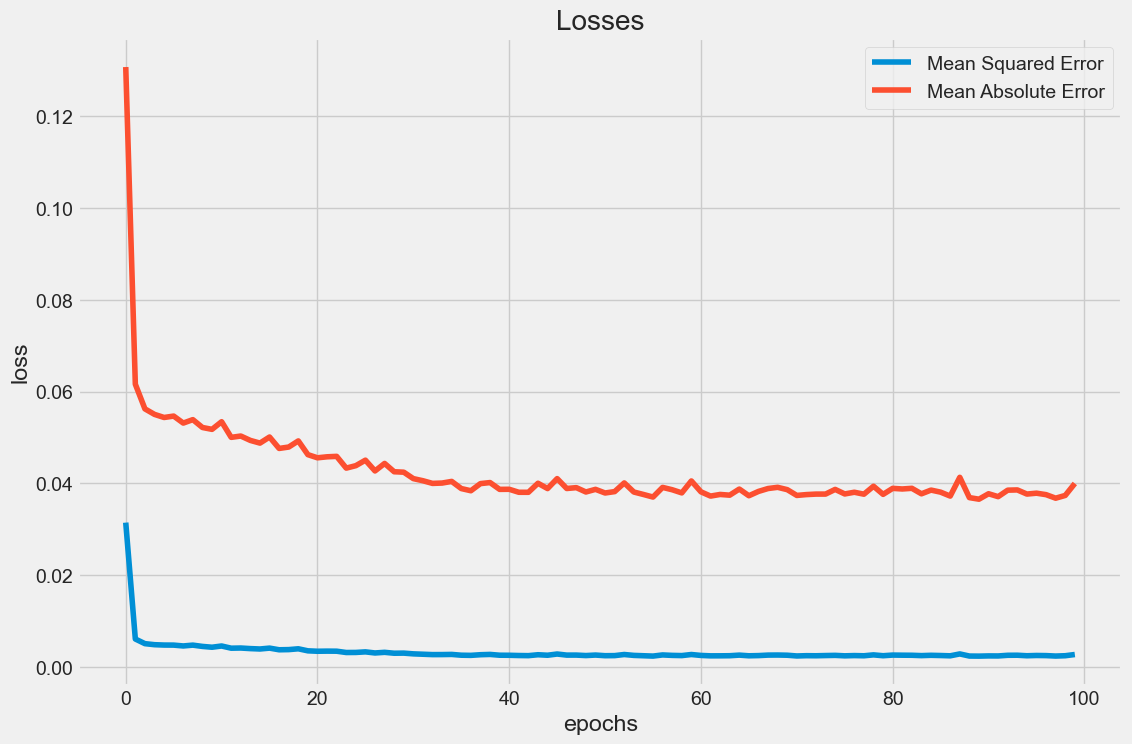

[codecarbon INFO @ 14:52:11] Energy consumed for RAM : 0.002580 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:52:11] Delta energy consumed for CPU with constant : 0.000467 kWh, power : 112.0 W
[codecarbon INFO @ 14:52:11] Energy consumed for All CPU : 0.014475 kWh
[codecarbon INFO @ 14:52:11] 0.017055 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:52:16] Energy consumed for RAM : 0.002747 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:52:16] Delta energy consumed for CPU with constant : 0.000466 kWh, power : 112.0 W
[codecarbon INFO @ 14:52:16] Energy consumed for All CPU : 0.015409 kWh
[codecarbon INFO @ 14:52:16] 0.018157 kWh of electricity used since the beginning.


In [33]:
plt.figure(figsize=(12, 8))
plt.plot(history.history["loss"])
plt.plot(history.history["mean_absolute_error"])
plt.legend(['Mean Squared Error','Mean Absolute Error'])
plt.title("Losses")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
# Stop tracker and get emissions
emissions = tracker.stop()
print(f"Emissions: {emissions} kg CO₂eq")

[codecarbon INFO @ 14:52:20] Energy consumed for RAM : 0.002627 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:52:20] Delta energy consumed for CPU with constant : 0.000260 kWh, power : 112.0 W
[codecarbon INFO @ 14:52:20] Energy consumed for All CPU : 0.014735 kWh
[codecarbon INFO @ 14:52:20] 0.017362 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:52:20] 0.005556 g.CO2eq/s mean an estimation of 175.21091110198878 kg.CO2eq/year


Emissions: 0.0026329530544432675 kg CO₂eq


[codecarbon INFO @ 14:52:31] Energy consumed for RAM : 0.002830 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:52:31] Delta energy consumed for CPU with constant : 0.000466 kWh, power : 112.0 W
[codecarbon INFO @ 14:52:31] Energy consumed for All CPU : 0.015876 kWh
[codecarbon INFO @ 14:52:31] 0.018706 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:52:46] Energy consumed for RAM : 0.002914 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:52:46] Delta energy consumed for CPU with constant : 0.000467 kWh, power : 112.0 W
[codecarbon INFO @ 14:52:46] Energy consumed for All CPU : 0.016342 kWh
[codecarbon INFO @ 14:52:46] 0.019256 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:53:01] Energy consumed for RAM : 0.002997 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:53:01] Delta energy consumed for CPU with constant : 0.000467 kWh, power : 112.0 W
[codecarbon INFO @ 14:53:01] Energy consumed for All CPU : 0.016809 kWh
[codecarbon INFO @ 14:53:01] 0.019806 k